In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [3]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

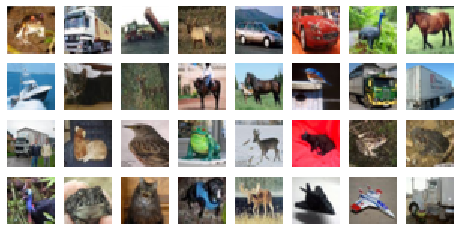

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [5]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

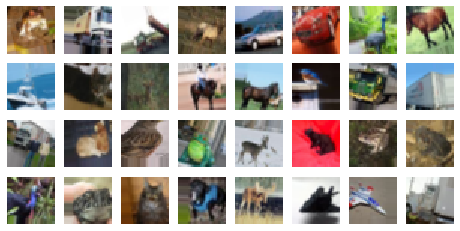

In [6]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_imgs = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_imgs.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

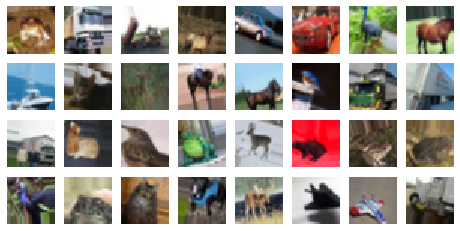

In [7]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_imgs = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_imgs.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
import os
import math

In [9]:
###超參數###
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

In [10]:
x_test = x_test.astype('float32')
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### 第1種圖像增強方法

In [11]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [12]:
data_generator.fit(x_train)

In [13]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)       

In [14]:
model.fit_generator(data_generator.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
                    steps_per_epoch=500,
                    epochs=epochs,
                    verbose=1)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
500/500 [==============================] - 269s 538ms/step - loss: 1.8782 - accuracy: 0.3144
Epoch 2/10
500/500 [==============================] - 238s 476ms/step - loss: 1.5545 - accuracy: 0.4412
Epoch 3/10
500/500 [==============================] - 248s 495ms/step - loss: 1.3906 - accuracy: 0.4995
Epoch 4/10
500/500 [==============================] - 230s 460ms/step - loss: 1.2945 - accuracy: 0.5403
Epoch 5/10
500/500 [==============================] - 229s 458ms/step - loss: 1.2358 - accuracy: 0.5612
Epoch 6/10
500/500 [==============================] - 229s 458ms/step - loss: 1.1833 - accuracy: 0.5831
Epoch 7/10
500/500 [==============================] - 243s 486ms/step - loss: 1.1413 - accuracy: 0.5983
Epoch 8/10
500/500 [==============================] - 235s 470ms/step - loss: 1.1135 - accuracy: 0.6143
Epoch 9/10
500/500 [==============================] - 242s 484ms/step - loss: 1.0880 - accuracy: 0.6201
Epoch 10/10
500/500 [==============================] - 229s 457m

### 第2種圖像增強方法

In [15]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [16]:
data_generator.fit(x_train)

In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)       

In [18]:
model.fit_generator(data_generator.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
                    steps_per_epoch=500,
                    epochs=epochs,
                    verbose=1)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
500/500 [==============================] - 250s 501ms/step - loss: 1.9183 - accuracy: 0.2962
Epoch 2/10
500/500 [==============================] - 237s 473ms/step - loss: 1.6784 - accuracy: 0.3931
Epoch 3/10
500/500 [==============================] - 255s 510ms/step - loss: 1.5580 - accuracy: 0.4420
Epoch 4/10
500/500 [==============================] - 234s 468ms/step - loss: 1.4742 - accuracy: 0.4721
Epoch 5/10
500/500 [==============================] - 244s 488ms/step - loss: 1.4154 - accuracy: 0.4936
Epoch 6/10
500/500 [==============================] - 231s 462ms/step - loss: 1.3633 - accuracy: 0.5117
Epoch 7/10
500/500 [==============================] - 250s 500ms/step - loss: 1.3272 - accuracy: 0.5246
Epoch 8/10
500/500 [==============================] - 236s 471ms/step - loss: 1.3001 - accuracy: 0.5365
Epoch 9/10
500/500 [==============================] - 244s 488ms/step - loss: 1.2729 - accuracy: 0.5484
Epoch 10/10
500/500 [==============================] - 234s 468m